In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import scipy
import librosa
import scipy.fftpack as fft
from scipy.signal import get_window
from IPython.display import Audio
import matplotlib.pyplot as plt

%matplotlib inline


In [4]:
from utils import *

# Problem 1: Complete MFCC Front End
Preemphasis algorithm taken from lecture slides  
Code for reference: https://www.kaggle.com/code/ilyamich/mfcc-implementation-and-tutorial  
Used librosa.features.delta for temporal derivatives

## Part a. 
Choose one of the vowels (preferably, the longest and most steady) in the pitch_gender1 sentence. Process the vowel through the system and examine and plot the log-spectrum of the output at each stage. Explain the effects of the different operations on the spectral shape of the speech sounds.

In [15]:
path = r"audio_files\pitch_gender1.wav"
y, sr = librosa.load(path, sr=44100)
Audio(path, rate=sr)

In [16]:
start_time = 1.967
end_time = 2.181
cropped = y[int(start_time*sr):int(end_time*sr)]
Audio(data=cropped,rate=sr)

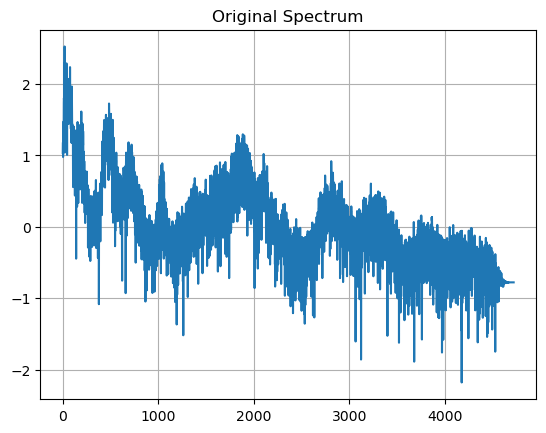

In [17]:
plt.title("Original Spectrum")
plt.plot(np.log10(np.abs(fft.fft(cropped,axis=0)[:len(cropped)//2])))
plt.grid(True)

In [18]:
# Preemphasis
preemphasized = preemphasis(signal=cropped)
Audio(data=preemphasized, rate=sr)

By applying a high-pass filter through pre-emphasis, the frequencies around 2000-3000 are amplified while the lower frequencies are slightly attenuated. Pre-emphasis, as the name suggests, emphasizes the higher frequencies so that higher frequencies are better represented.

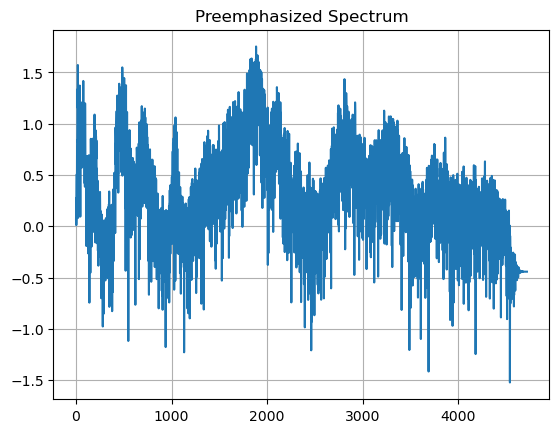

In [19]:
plt.title("Preemphasized Spectrum")
plt.plot(np.log10(np.abs(fft.fft(preemphasized,axis=0)[:len(preemphasized)//2])))
plt.grid(True)

In [20]:
# Frame audio
frames = frame_audio(preemphasized)
print(frames.shape)

(22, 1024)


The audio is separated into different frames based on the hop size, which is set at a default of 10 ms. The length of each frame is based on the desired FFT size, which is set to 1024 samples, or 23 ms. In the time domain, each frame is tapered off near the ends due to the weighting that is applied by the Hamming window. This is important because it removes unwanted high frequency artifacts.

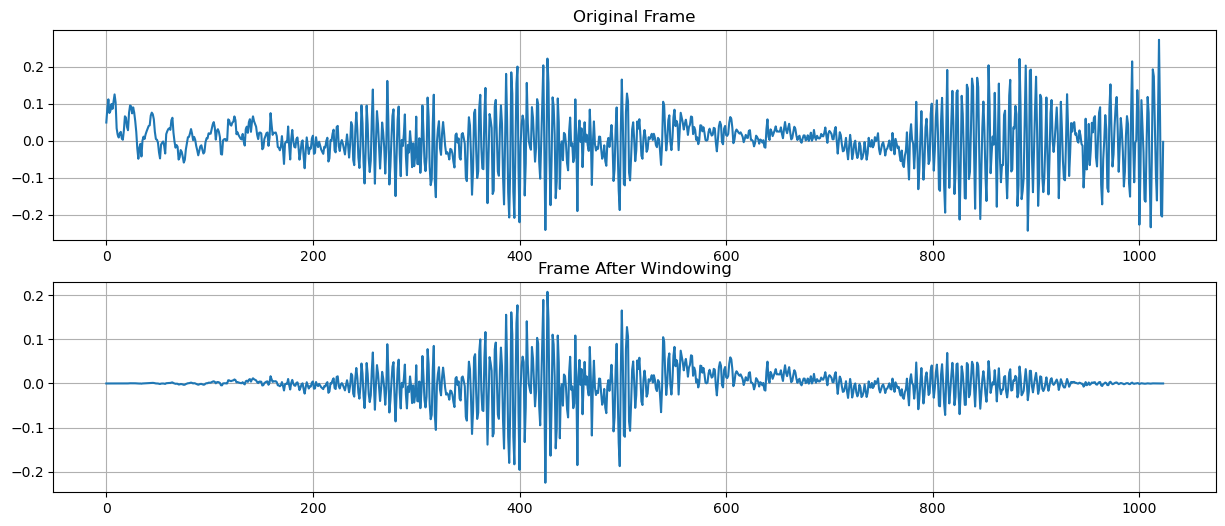

In [21]:
# Window frames
windowed = window_frames(frames)
ind = 12
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(frames[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(windowed[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In the frequency domain, it can be observed the spectrum exhibits much less spectral noise when compared to the spectrum of the original frame without windowing. The no window situation can be thought of as applying a simple rectangular window. The Hamming window has frequency domain representation with much smaller side lobes than that of the rectangular window. As a result, when the spectrums of each window are convolved with the frames, the spectral leakage is much better contained in the case with the Hamming window.

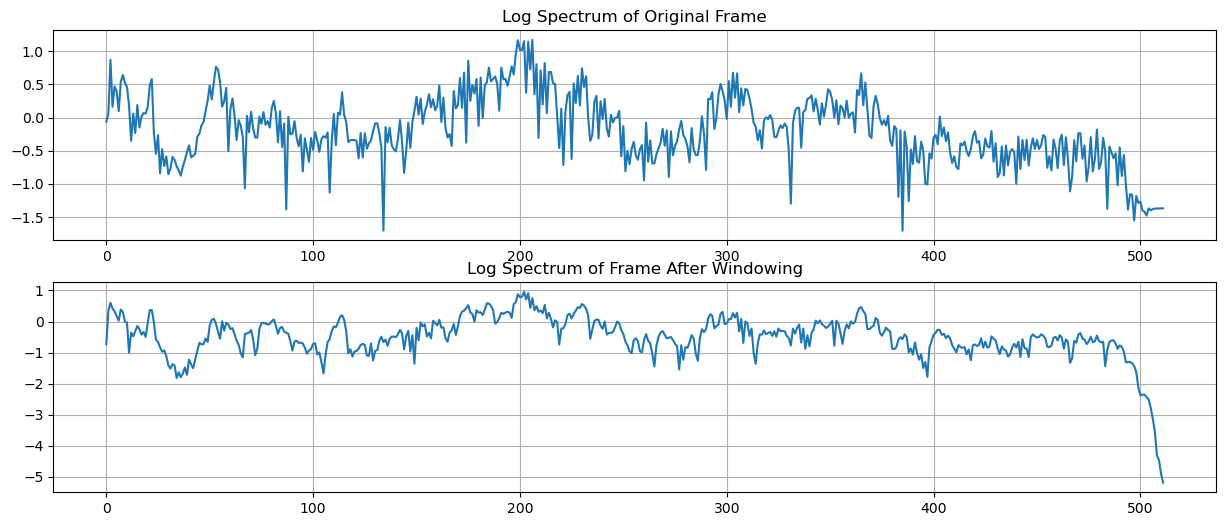

In [22]:
ind = 12
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(np.log10(np.abs(fft.fft(frames[ind],axis=0)))[:len(frames[ind])//2])
plt.title('Log Spectrum of Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(np.log10(np.abs(fft.fft(windowed[ind],axis=0)))[:len(windowed[ind])//2])
plt.title('Log Spectrum of Frame After Windowing')
plt.grid(True)

The function fft_frames calculates the FFT of each window which is then used to calculate the power spectrum. Since the FFT size is 1024, the DFT is periodic with a period of 1024 ($2\pi$ in the DTFT domain), which means we need only consider the frequencies from index -512 to +512 (-$\pi$ to +$\pi$). Since we know that speech is a real-valued signal, the frequency domain is conjugate symmetric, which means that we can further reduce the frequencies for consideration to indices 0 to +512 (0 to +$\pi$). In other words, only half of the spectrum is needed to completely represent the audio signal. The power spectrum takes the squared magnitude of the log spectrum, which makes clear which frequencies are dominant.

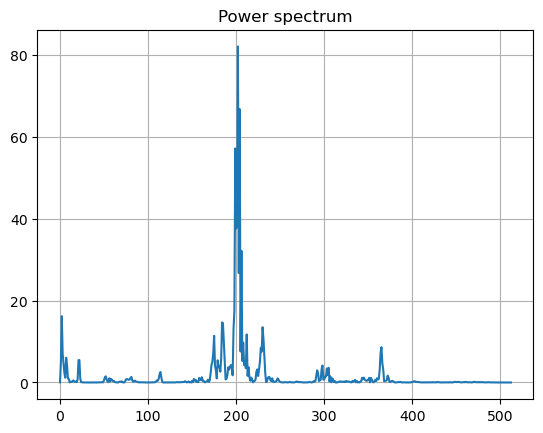

In [24]:
audio_power = fft_frames(windowed)
plt.plot(audio_power[ind])
plt.title('Power spectrum')
plt.grid(True)

In [25]:
freq_min = 0
freq_high = sr / 2
mel_filter_num = 40
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, sample_rate=44100)
filter_points
print(filter_points)
print(mel_freqs)

MEL min: 0.0
MEL max: 3923.337321740179
[  0   1   3   4   6   8  10  13  15  18  21  25  28  32  37  41  47  52
  58  65  72  80  89  98 108 119 131 144 159 174 191 209 229 251 275 301
 329 360 393 429 469 512]
[    0.            62.03206123   129.56123192   203.07465067
   283.102625     370.22245675   465.0626067    568.30722807
   680.70110182   803.05500937   936.25158133  1081.25166459
  1239.10125362  1410.93903604  1598.00460681  1801.64741034
  2023.3364751   2264.67101077  2527.39194458  2813.39447989
  3124.74176774  3463.67978992  3832.65356087  4234.32476547
  4671.59095972  5147.60647302  5665.8051627   6229.92518502
  6844.03596129  7512.56753367  8240.34252238  9032.61091489
  9895.08793802 10833.99528616 11856.10600303 12968.79334071
 14180.08394848 15498.71577503 16934.20110187 18496.89516255
 20198.07084273 22050.        ]


The indices and corresponding frequencies of the endpoints of our triangular mel filters are calculated. Using np.linspace, we can then calculate the up and down slopes of each triangular filter.

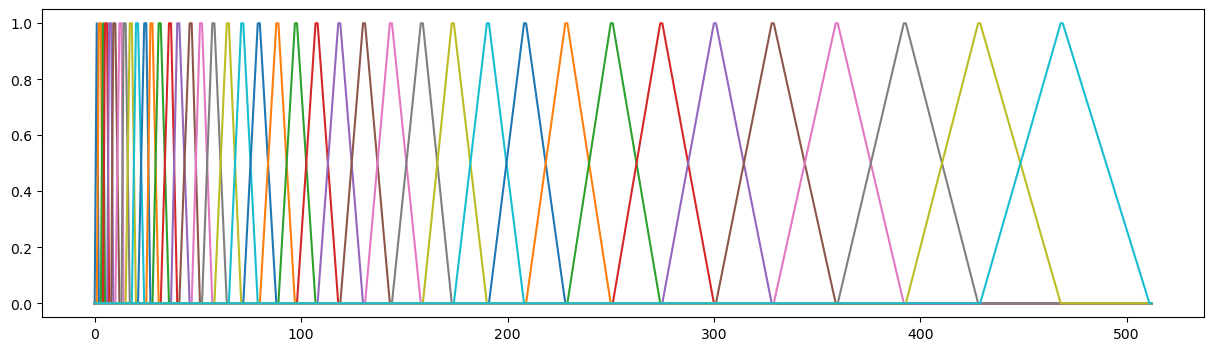

In [32]:
filters = get_filters(filter_points)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

We need to normalize each filter based on its width so we don't amplify unwanted high frequencies.

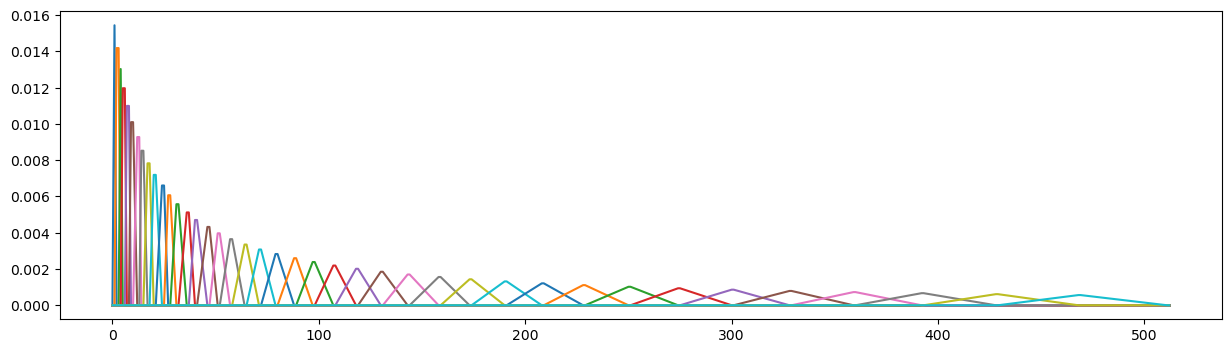

In [33]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])


By using matrix multiplication, for each filter, we can weight the frequency components and bin them together. We then compute the base 10 logarithm of the spectrum.

(40, 22)


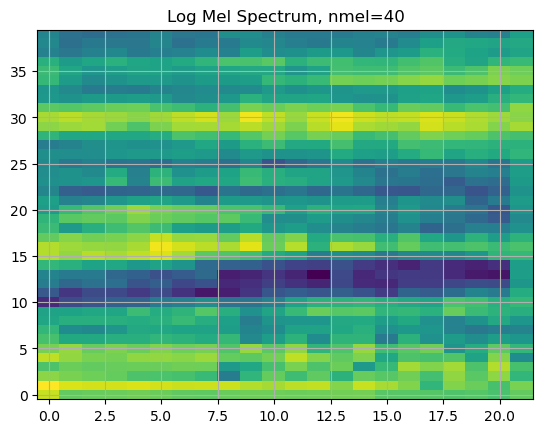

In [48]:
audio_filtered = filters@audio_power.T
audio_log = 10*np.log10(audio_filtered+1e-9)
print(audio_log.shape)
plt.imshow(audio_log, aspect='auto', origin='lower')
plt.title(f'Log Mel Spectrum, nmel={mel_filter_num}')
plt.grid(True)

The Mel-scale filterbank weights frequency components around each mel-scale center frequency using triangular filters and bins them together, which is similar to human hearing. I chose nmel=40, which means there are 40 bins.

In [49]:
dct_filter_num = 13

dct_filters = dct(dct_filter_num, mel_filter_num)

mfcc_13 = dct_filters @ audio_log
print(mfcc_13.shape)

mfcc_13_weighted = parameter_weighting(mfcc_13)
mfcc_13_delta_1 = librosa.feature.delta(mfcc_13_weighted, order=1, axis=1)
mfcc_13_delta_2 = librosa.feature.delta(mfcc_13_weighted, order=2, axis=1)

(13, 22)


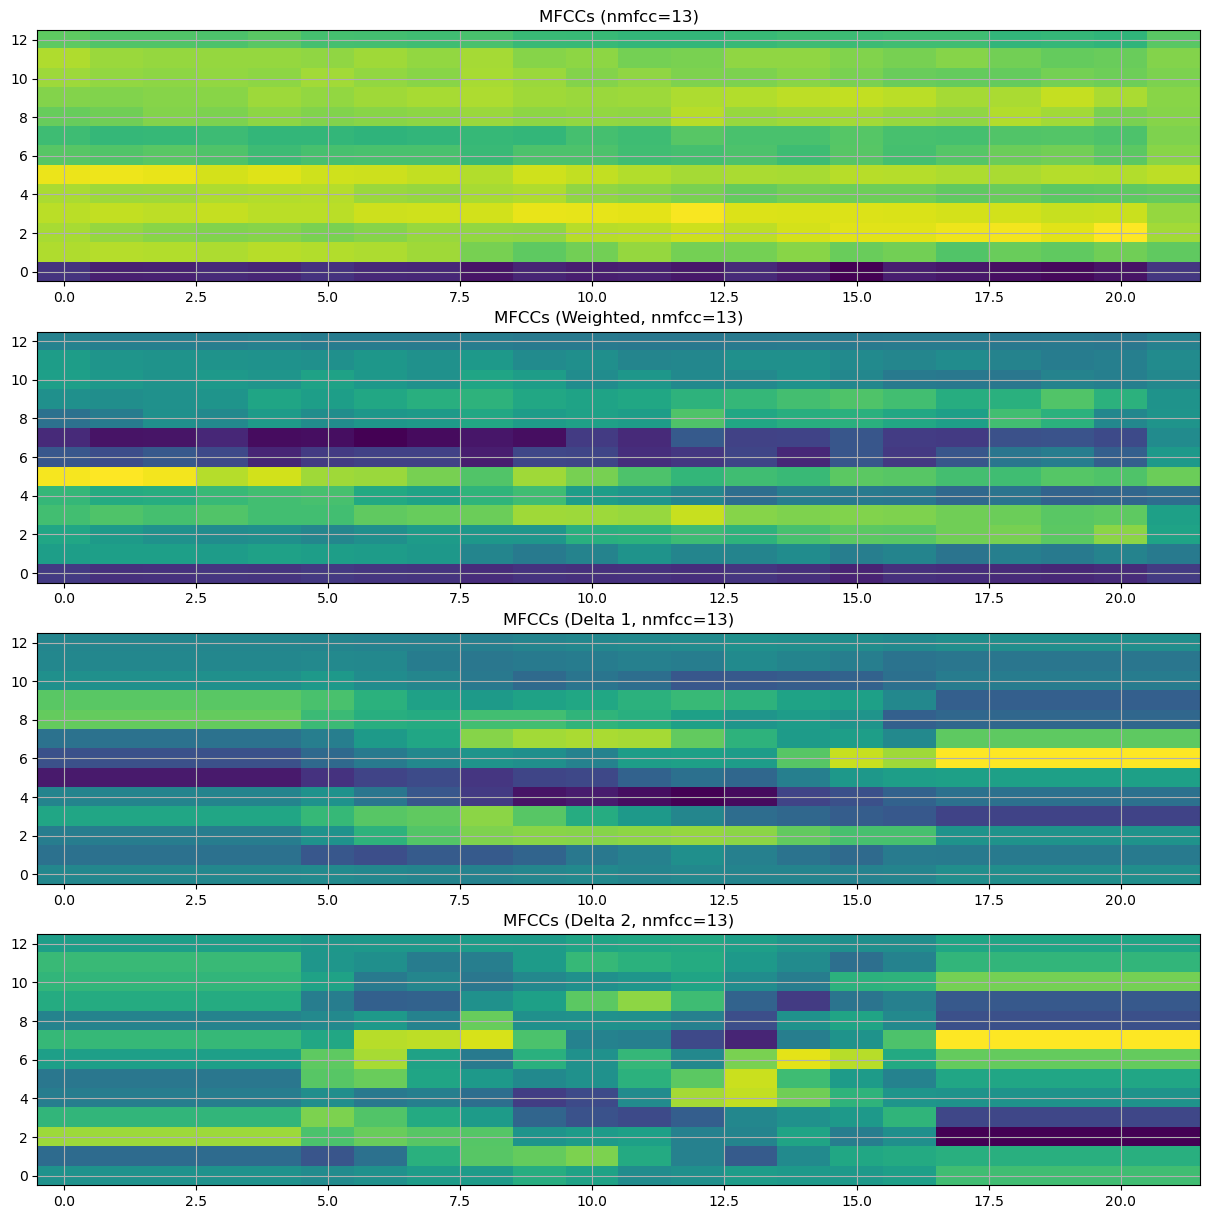

In [53]:
plt.figure(figsize=(15,15))
plt.subplot(4, 1, 1)
plt.imshow(mfcc_13, aspect='auto', origin='lower')
plt.title(f'MFCCs (nmfcc={dct_filter_num})')
plt.grid(True)
plt.subplot(4, 1, 2)
plt.imshow(mfcc_13_weighted, aspect='auto', origin='lower')
plt.title(f'MFCCs (Weighted, nmfcc={dct_filter_num})')
plt.grid(True)
plt.subplot(4, 1, 3)
plt.imshow(mfcc_13_delta_1, aspect='auto', origin='lower')
plt.title(f'MFCCs (Delta 1, nmfcc={dct_filter_num})')
plt.grid(True)
plt.subplot(4, 1, 4)
plt.imshow(mfcc_13_delta_2, aspect='auto', origin='lower')
plt.title(f'MFCCs (Delta 2, nmfcc={dct_filter_num})')
plt.grid(True)

The DCT computes coefficients that describe how the log mel spectrum can be decomposed into weighted cosines, in a sense capturing the frequency components of the log mel spectrum (spectrum of the spectrum). The first couple coefficients capture the overall shape of the spectrum.

Parameter weighting applies a window in the cepstrum to weight the cepstral coefficients, allowing certain coefficients to be emphasized more than others.

Delta 1 and delta 2 features examine how the cepstral coefficients change with respect to time (velocity and acceleration respectively).

## Part b.
What is the effect of increasing the number of cepstral coefficients?  
  
The cepstral coefficients describe how the log mel spectrum can be decomposed into weighted cosines that capture the different frequency components of the spectrum. By increasing the number of cepstral coefficients, more information from the log mel spectrum is retained. While the first couple MFCCs are the most important since they capture the overall shape of the spectrum, it seems that increasing the number of MFCCs up to 100 captures a peak at the 80th MFCC. Higher-order coefficients define the high frequency periodicities in the frequency spectrum. A peak at the 80th MFCC indicates presence of timbre, texture, and/or spectral noise.

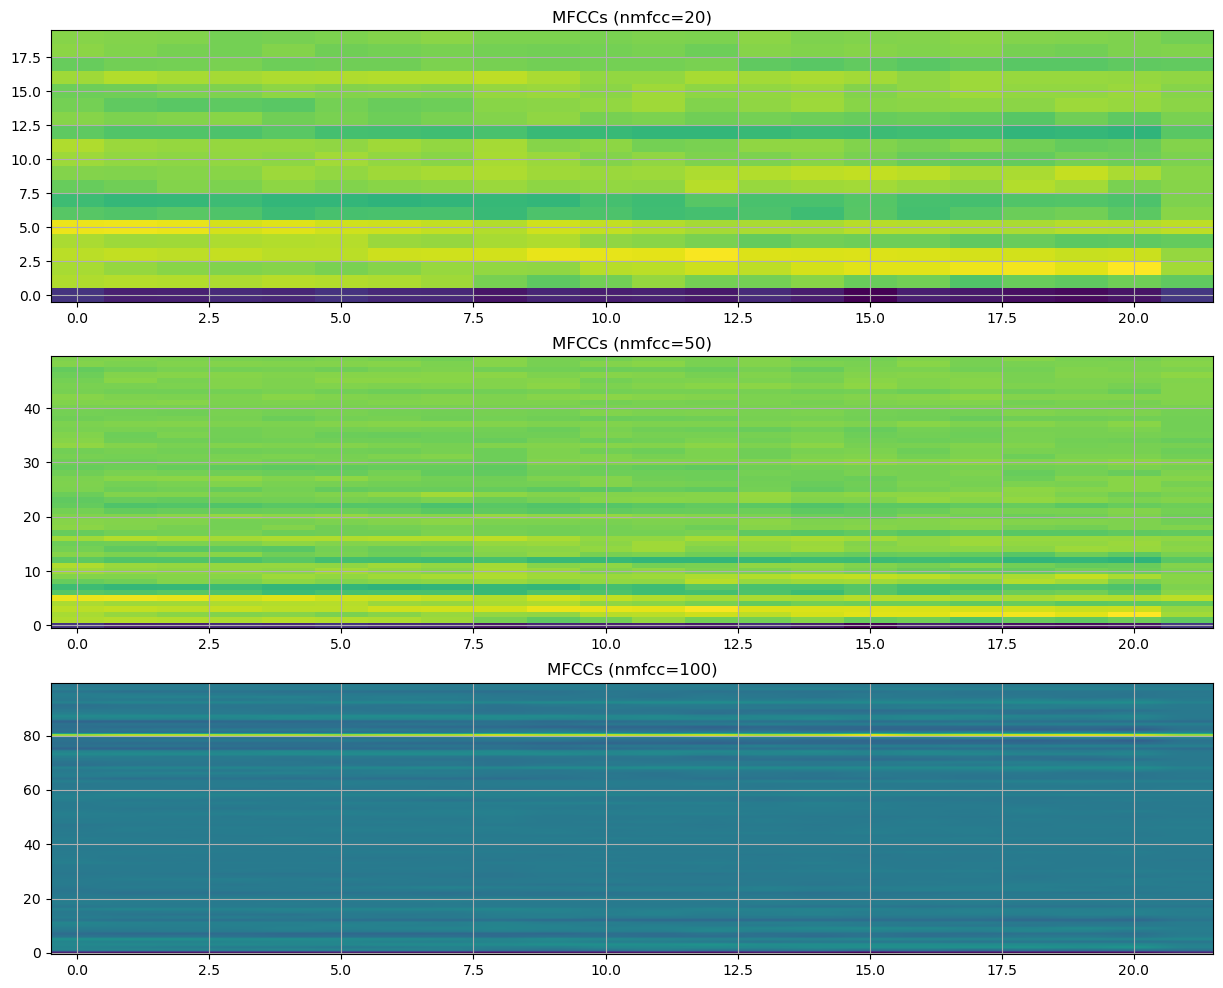

In [37]:
dct_filter_num = 20
dct_filters = dct(dct_filter_num, mel_filter_num)
mfcc_20 = dct_filters @ audio_log

dct_filter_num = 50
dct_filters = dct(dct_filter_num, mel_filter_num)
mfcc_50 = dct_filters @ audio_log

dct_filter_num = 100
dct_filters = dct(dct_filter_num, mel_filter_num)
mfcc_100 = dct_filters @ audio_log

plt.figure(figsize=(15,12))
plt.subplot(3, 1, 1)
plt.imshow(mfcc_20, aspect='auto', origin='lower')
plt.title('MFCCs (nmfcc=20)')
plt.grid(True)
plt.subplot(3, 1, 2)
plt.imshow(mfcc_50, aspect='auto', origin='lower')
plt.title('MFCCs (nmfcc=50)')
plt.grid(True)
plt.subplot(3, 1, 3)
plt.imshow(mfcc_100, aspect='auto', origin='lower')
plt.title('MFCCs (nmfcc=100)')
plt.grid(True)

In [38]:
print(np.argmax(mfcc_100[:,0]))

80


## Part c.
It is often thought that the low-order cepstral coefficients are more related to vocal tract information while higher-order ones, to pitch. Can you see any evidence of that? To do this part use synthetic vowels posted on the
website. The vowels are /a/ and /i/ with F0 at 100 and 150 Hz for male vowels, and 150 and 200 Hz for the female ones. Examine the effect on the cepstral coefficients when F0 is changed but the formants are fixed, versus changing the formants (male vs. female) while keeping F0 the same.

In [70]:
# we set sampling rate to 44.1 kHz for every file (librosa.load will upsample correctly) so that FFT size can stay fixed
path_m_a_100 = r'.\audio_files\male_a_100.wav'
y_m_a_100, sr_m_a_100 = librosa.load(path_m_a_100, sr=44100)
print(sr_m_a_100)
Audio(y_m_a_100, rate=sr_m_a_100)

44100


In [66]:
path_m_a_150 = r'.\audio_files\male_a_150.wav'
y_m_a_150, sr_m_a_150 = librosa.load(path_m_a_150, sr=44100)
print(sr_m_a_150)
Audio(y_m_a_150, rate=sr_m_a_150)

44100


In [67]:
path_f_a_150 = r'.\audio_files\female_a_150.wav'
y_f_a_150, sr_f_a_150 = librosa.load(path_f_a_150, sr=44100)
print(sr_f_a_150)
Audio(y_f_a_150, rate=sr_f_a_150)

44100


In [68]:
path_f_i_200 = r'.\audio_files\female_i_200.wav'
y_f_i_200, sr_f_i_200 = librosa.load(path_f_i_200, sr=44100)
print(sr_f_i_200)
Audio(y_f_i_200, rate=sr_f_i_200)

44100


In [129]:
nmfcc = 100
feat_m_a_100 = librosa.feature.mfcc(y=y_m_a_100, sr=sr_m_a_100, n_mfcc=nmfcc)
feat_m_a_150 = librosa.feature.mfcc(y=y_m_a_150, sr=sr_m_a_150, n_mfcc=nmfcc)
feat_f_a_150 = librosa.feature.mfcc(y=y_f_a_150, sr=sr_f_a_150, n_mfcc=nmfcc)
feat_f_i_200 = librosa.feature.mfcc(y=y_f_i_200, sr=sr_f_i_200, n_mfcc=nmfcc)

In the male speaker examples, there is very faint pitch information around the 80th MFCC for the $F_0 = 100$ example. Increasing $F_0$ to 150, we can observe that the pitch information moves down to approximately the 55th MFCC. The same behavior can be seen in the female examples. This happens because as pitch increases, the periodicities in the frequency spectrum that are pitch-related are more spaced out apart. Because the cepstrum is the spectrum of the spectrum, the more spaced out periodicities lead to spikes in lower order coefficients.

Changing the formants while keeping the pitch the same, most of the difference can already be seen in the first 20 MFCCs. This is because these coefficients carry most of the information about the general shape of the frequency spectrum. This shape of the spectrum is dictated by the formants.

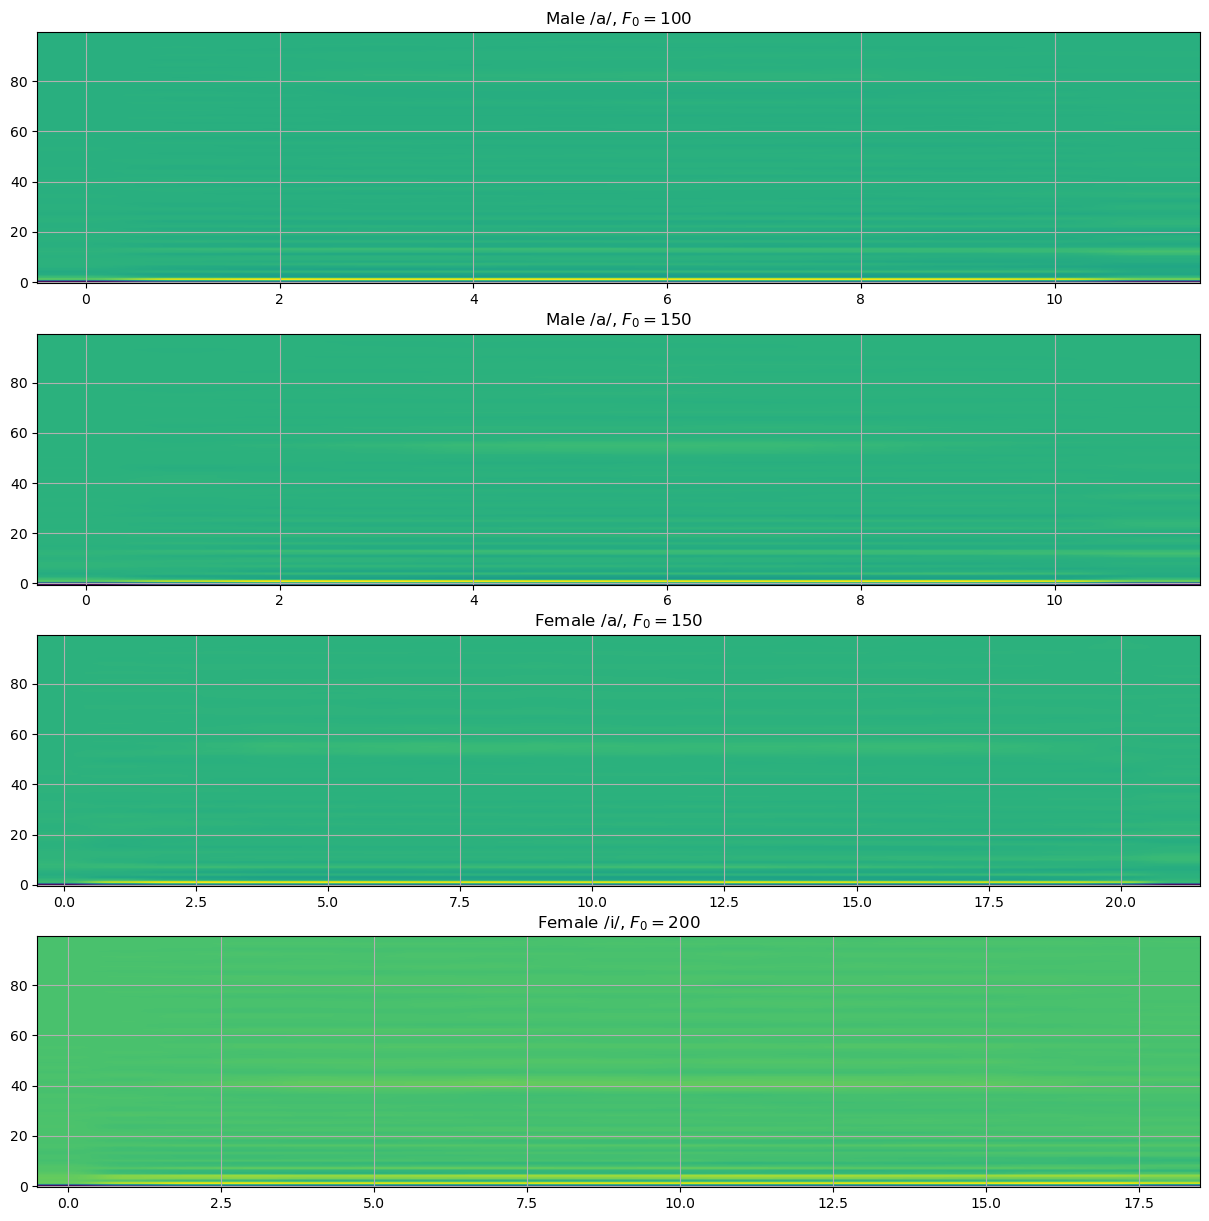

In [130]:
plt.figure(figsize=(15,15))
plt.subplot(4, 1, 1)
plt.imshow(feat_m_a_100, aspect='auto', origin='lower')
plt.title('Male /a/, $F_0=100$')
plt.grid(True)
plt.subplot(4, 1, 2)
plt.imshow(feat_m_a_150, aspect='auto', origin='lower')
plt.title('Male /a/, $F_0=150$')
plt.grid(True)
plt.subplot(4, 1, 3)
plt.imshow(feat_f_a_150, aspect='auto', origin='lower')
plt.title('Female /a/, $F_0=150$')
plt.grid(True)
plt.subplot(4, 1, 4)
plt.imshow(feat_f_i_200, aspect='auto', origin='lower')
plt.title('Female /i/, $F_0=200$')
plt.grid(True)

## Part d.
For the male and female /a/ vowels with fundamental frequency at 150 Hz, add 10 dB SNR white Gaussian random noise to the waveform and plot cepstral coefficients for all the frames. On the same figure, plot cepstral coefficients of clean waveform. Comment on the differences. Are MFCC features robust to noise?

In [114]:
nmfcc = 13
y_m_a_150_n = add_noise(y_m_a_150, 10)
y_f_a_150_n = add_noise(y_f_a_150, 10)
feat_m_a_150 = librosa.feature.mfcc(y=y_m_a_150, sr=sr_m_a_150, n_mfcc=nmfcc)
feat_f_a_150 = librosa.feature.mfcc(y=y_f_a_150, sr=sr_f_a_150, n_mfcc=nmfcc)
feat_m_a_150_n = librosa.feature.mfcc(y=y_m_a_150_n, sr=sr_m_a_150, n_mfcc=nmfcc)
feat_f_a_150_n = librosa.feature.mfcc(y=y_f_a_150_n, sr=sr_f_a_150, n_mfcc=nmfcc)

The noisy cepstral coefficients exhibit differences from the clean coefficients. While the peaks around the first cepstral coefficient are preserved even through the noise, the coefficients from the 2nd onward differ from the clean version. MFCC features exhibit some robustness to noise.

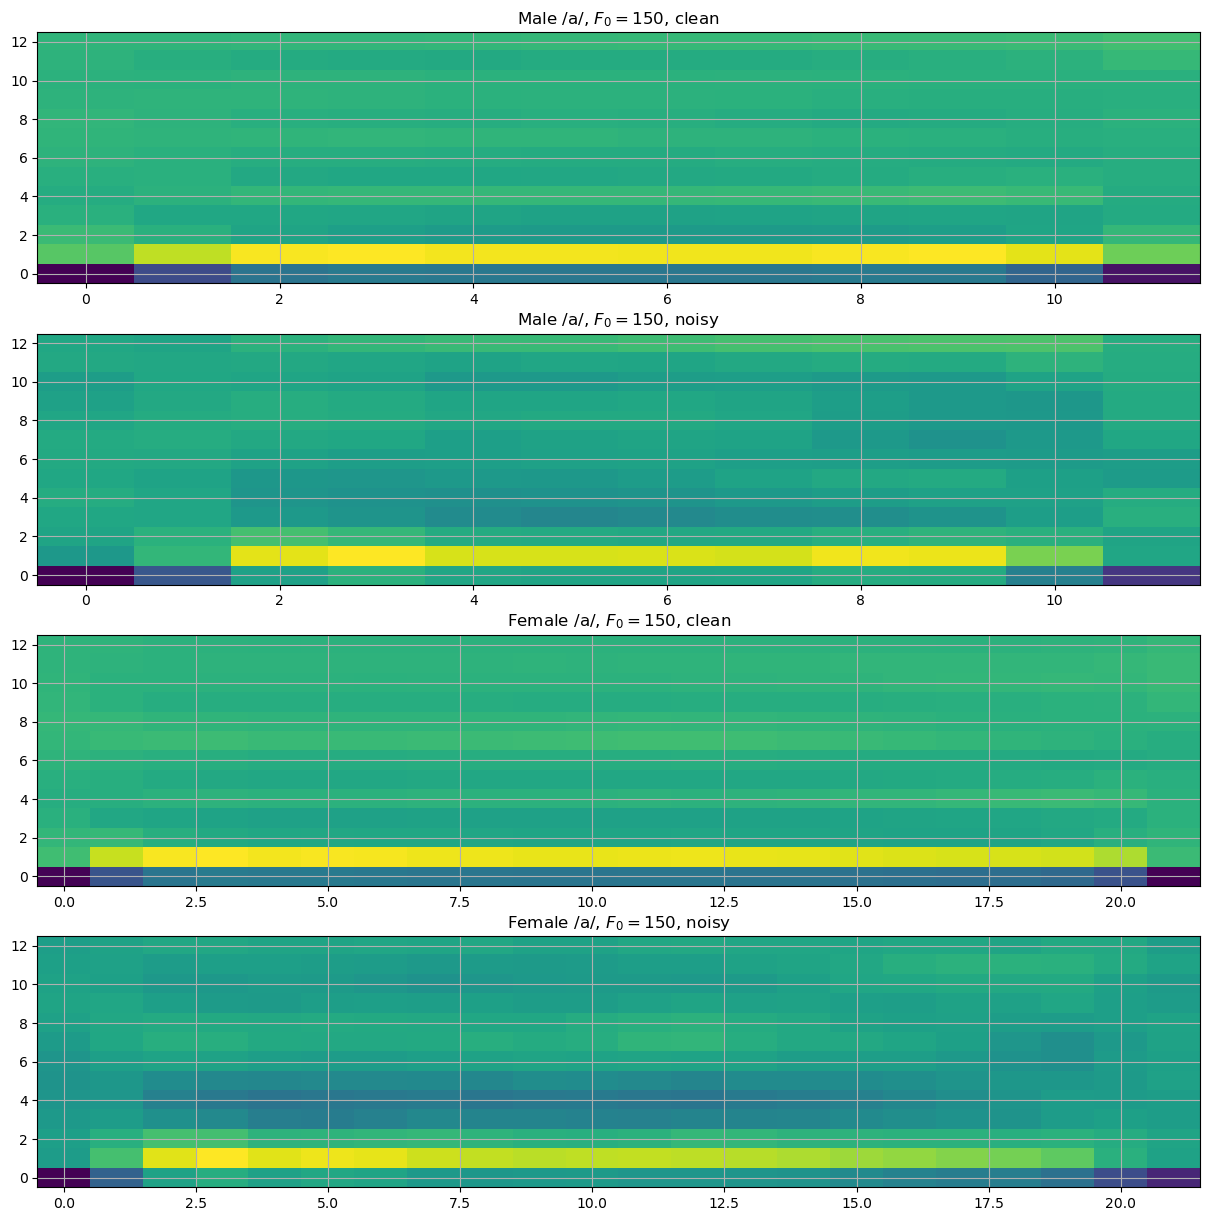

In [117]:
plt.figure(figsize=(15,15))
plt.subplot(4, 1, 1)
plt.imshow(feat_m_a_150, aspect='auto', origin='lower')
plt.title('Male /a/, $F_0=150$, clean')
plt.grid(True)
plt.subplot(4, 1, 2)
plt.imshow(feat_m_a_150_n, aspect='auto', origin='lower')
plt.title('Male /a/, $F_0=150$, noisy')
plt.grid(True)
plt.subplot(4, 1, 3)
plt.imshow(feat_f_a_150, aspect='auto', origin='lower')
plt.title('Female /a/, $F_0=150$, clean')
plt.grid(True)
plt.subplot(4, 1, 4)
plt.imshow(feat_f_a_150_n, aspect='auto', origin='lower')
plt.title('Female /a/, $F_0=150$, noisy')
plt.grid(True)

# Complete LPCC Front End
Preemphasis and frame blocking code same as MFCC front end  
Used librosa.lpc to convert windowed frames into LPC  (Burg's Method for LPC parameter estimation by autocorrelation)  
Conversion from LPC to LPCC taken from: https://www.mathworks.com/help/dsp/ref/lpctofromcepstralcoefficients.html  
Parameter weighting taken from slides  
Used librosa.features.delta for temporal derivatives

## Part c.
It is often thought that the low-order cepstral coefficients are more related to vocal tract information while higher-order ones, to pitch. Can you see any evidence of that? To do this part use synthetic vowels posted on the
website. The vowels are /a/ and /i/ with F0 at 100 and 150 Hz for male vowels, and 150 and 200 Hz for the female ones. Examine the effect on the cepstral coefficients when F0 is changed but the formants are fixed, versus changing the formants (male vs. female) while keeping F0 the same.

In [140]:
path_m_a_100 = r'.\audio_files\male_a_100.wav'
y_m_a_100, sr_m_a_100 = librosa.load(path_m_a_100, sr=44100)
path_m_a_150 = r'.\audio_files\male_a_150.wav'
y_m_a_150, sr_m_a_150 = librosa.load(path_m_a_150, sr=44100)
path_f_a_150 = r'.\audio_files\female_a_150.wav'
y_f_a_150, sr_f_a_150 = librosa.load(path_f_a_150, sr=44100)
path_f_i_200 = r'.\audio_files\female_i_200.wav'
y_f_i_200, sr_f_i_200 = librosa.load(path_f_i_200, sr=44100)

In [141]:
nlpcc = 13
_,feat_m_a_100,_,_ = lpcc(y=y_m_a_100, n_lpcc=nlpcc)
_,feat_m_a_150,_,_ = lpcc(y=y_m_a_150, n_lpcc=nlpcc)
_,feat_f_a_150,_,_ = lpcc(y=y_f_a_150, n_lpcc=nlpcc)
_,feat_f_i_200,_,_ = lpcc(y=y_f_i_200, n_lpcc=nlpcc)

Keeping the formants the same while increasing $F_0$ induces some changes in the coefficients from around the 4th coefficient onwards. Keeping $F_0$ the same while changing the formants induces some changes in the lower order coefficients. This makes sense as formants carry the overall structure of the frequency spectrum which correspond to low frequency components, while $F_0$ creates more refined periodicities which correspond to higher frequency components.

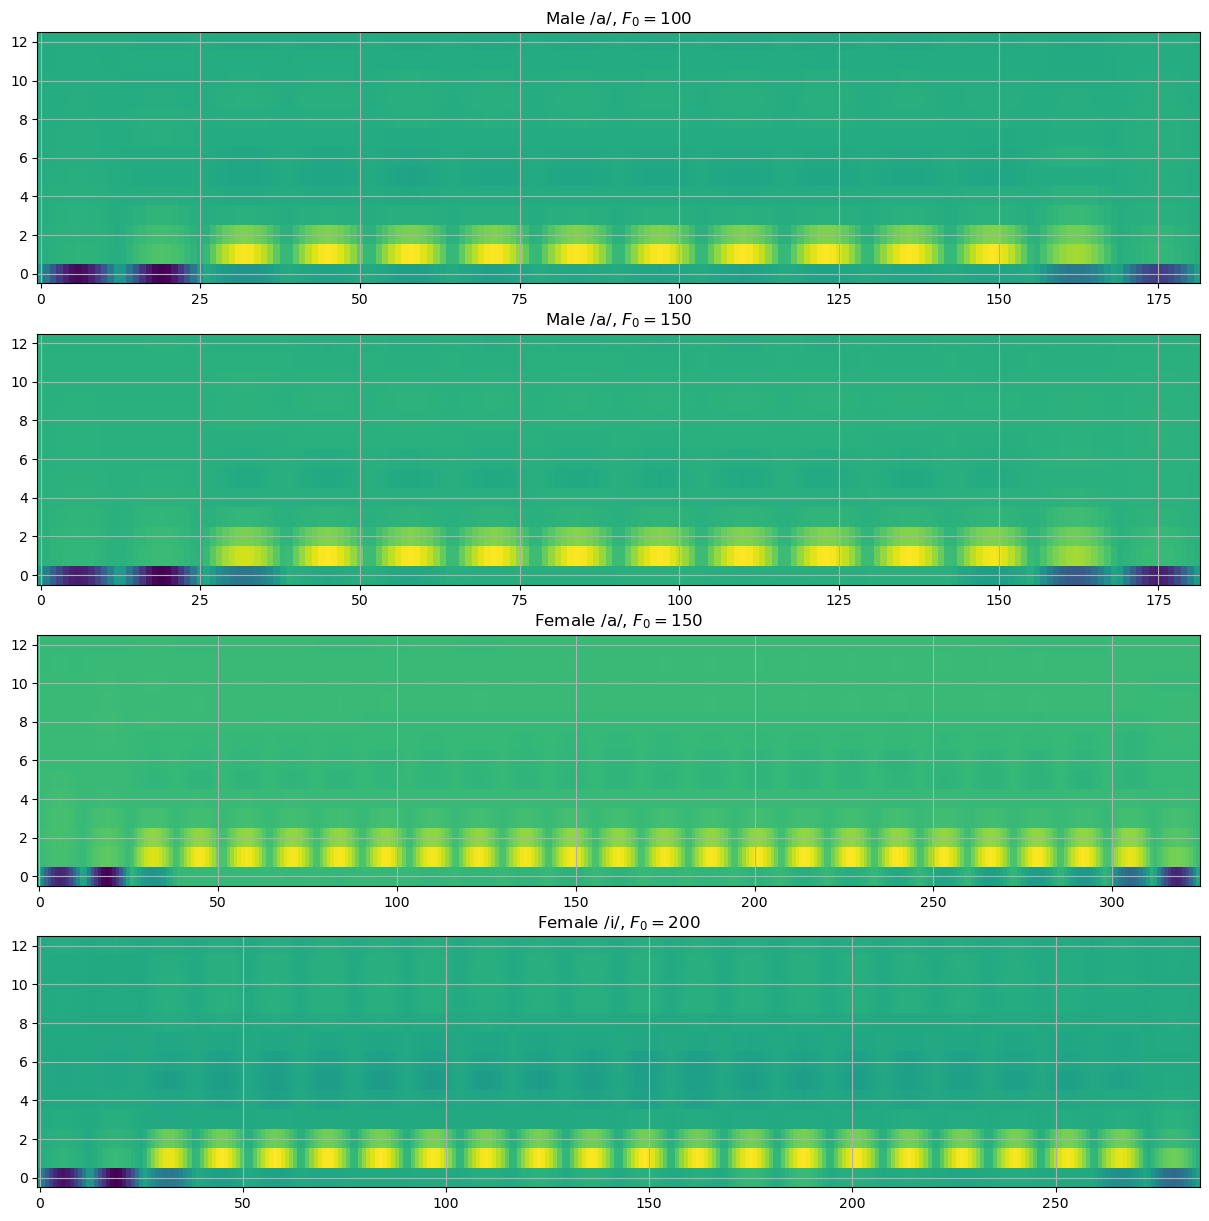

In [136]:
plt.figure(figsize=(15,15))
plt.subplot(4, 1, 1)
plt.imshow(feat_m_a_100, aspect='auto', origin='lower')
plt.title('Male /a/, $F_0=100$')
plt.grid(True)
plt.subplot(4, 1, 2)
plt.imshow(feat_m_a_150, aspect='auto', origin='lower')
plt.title('Male /a/, $F_0=150$')
plt.grid(True)
plt.subplot(4, 1, 3)
plt.imshow(feat_f_a_150, aspect='auto', origin='lower')
plt.title('Female /a/, $F_0=150$')
plt.grid(True)
plt.subplot(4, 1, 4)
plt.imshow(feat_f_i_200, aspect='auto', origin='lower')
plt.title('Female /i/, $F_0=200$')
plt.grid(True)

## Part d.
For the male and female /a/ vowels with fundamental frequency at 150 Hz, add 10 dB SNR white Gaussian random noise to the waveform and plot cepstral coefficients for all the frames. On the same figure, plot cepstral coefficients of clean waveform. Comment on the differences. Are LPCC features robust to noise?

In [144]:
nlpcc = 13
y_m_a_150_n = add_noise(y_m_a_150, 10)
y_f_a_150_n = add_noise(y_f_a_150, 10)
_,feat_m_a_150_n,_,_ = lpcc(y=y_m_a_150_n, n_lpcc=nlpcc)
_,feat_f_a_150_n,_,_ = lpcc(y=y_f_a_150_n, n_lpcc=nlpcc)

The noisy cepstral coefficients exhibit a lot of added and unwanted artifacts in all coefficients. Since white Gaussian noise exists across all frequencies, this makes sense. LPCC features are not robust to noise; the noisy versions seem to differ from the clean versions a lot more drastically than MFCCs.

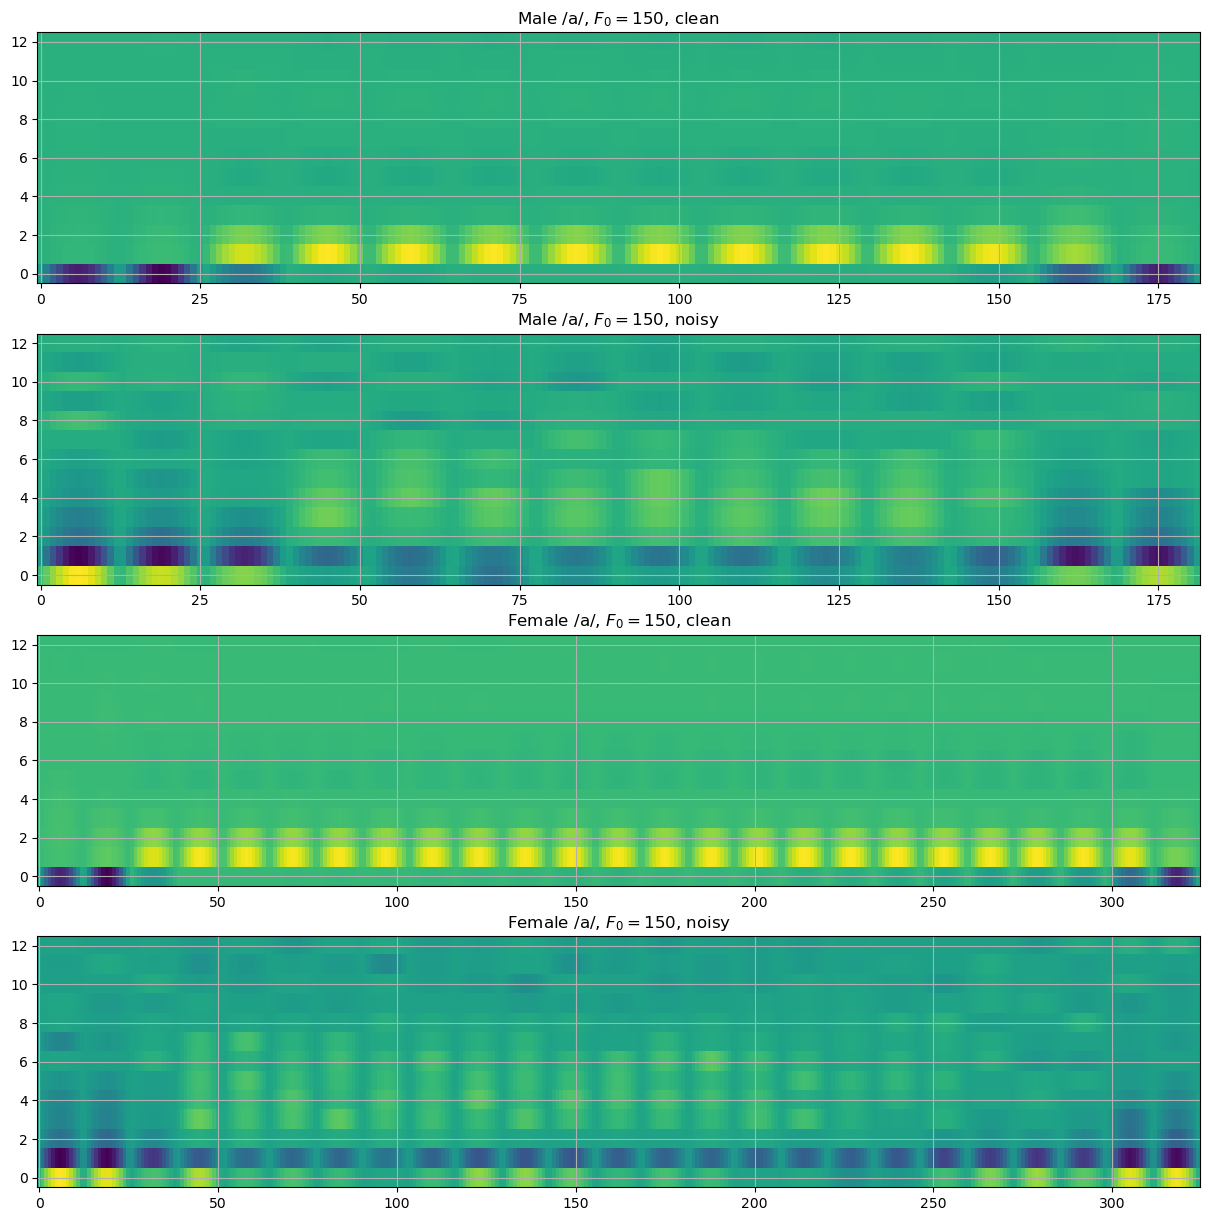

In [145]:
plt.figure(figsize=(15,15))
plt.subplot(4, 1, 1)
plt.imshow(feat_m_a_150, aspect='auto', origin='lower')
plt.title('Male /a/, $F_0=150$, clean')
plt.grid(True)
plt.subplot(4, 1, 2)
plt.imshow(feat_m_a_150_n, aspect='auto', origin='lower')
plt.title('Male /a/, $F_0=150$, noisy')
plt.grid(True)
plt.subplot(4, 1, 3)
plt.imshow(feat_f_a_150, aspect='auto', origin='lower')
plt.title('Female /a/, $F_0=150$, clean')
plt.grid(True)
plt.subplot(4, 1, 4)
plt.imshow(feat_f_a_150_n, aspect='auto', origin='lower')
plt.title('Female /a/, $F_0=150$, noisy')
plt.grid(True)